# Imports packages

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [58]:
random_state = 100
np.random.seed(random_state)

# Sigmoid

In [59]:
def sigmoid(z):
    s = 1./(1.+np.exp(-z))
    return s

def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.
    return w, b

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    m = X.shape[1]
    #print('number of objects = ',len(X))

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

# Logistic regression method (GD)
From original notebook

In [60]:
# optimize
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

# predict
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction

# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    X_train = X_train.T
    X_test = X_test.T

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("\ttrain accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("\ttest accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

# Stochastic gradient descent method (SGD)

In [61]:
# optimize SGD
def optimize_sgd(w, b, X, Y, num_iterations, learning_rate, batch_size=5, print_cost=False):
    """
    batch_size -- size of the batch of samples
    """
    costs = []
    dw, db = None, None
    batch_size = min(X.shape[1], batch_size)

    for i in range(num_iterations):
        batch_idx = np.random.choice(X.shape[1], batch_size ,replace=False)
        sub_x = X[:, batch_idx]
        sub_y = Y[batch_idx]

        # Cost and gradient calculation
        grads, cost = propagate(w, b, sub_x, sub_y)

        # For loss result
        _, cost_j = propagate(w, b, X, Y)

        dw, db = grads["dw"], grads["db"]

        w -= learning_rate * dw
        b -= learning_rate * db

        costs.append(cost_j)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_j))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

# model SGD
def model_sgd(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, batch_size=5, print_cost=False):
    X_train = X_train.T
    X_test = X_test.T

    w, b = initialize_with_zeros(X_train.shape[0])

    params, grads, costs = optimize_sgd(w, b, X_train, Y_train, num_iterations, learning_rate, batch_size, print_cost)

    w, b = params["w"], params["b"]

    y_prediction_test = predict(w, b, X_test)
    y_prediction_train = predict(w, b, X_train)

    print("\ttrain accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_train - Y_train)) * 100))
    print("\ttest accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_test - Y_test)) * 100))

    d = {
        "costs": costs,
        "Y_prediction_test": y_prediction_test,
        "Y_prediction_train" : y_prediction_train,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations
    }

    return d

In [62]:
# optimize Adam
def optimize_adam(w, b, X, Y, num_iterations, learning_rate,
                  b_1=0.3, b_2=0.999, eps=1e-8, batch_size=5, print_cost=False):
    """
    b_1 and b_2 -- learning parameters of Adam optimizer
    eps -- threshold.
    """
    costs = []

    #Initialization of the parameters for Adam optimizer
    v, s = 0, 0
    dw, db = None, None
    batch_size = min(X.shape[1], batch_size)

    for i in range(num_iterations):
        #batch selection
        batch_ids = np.random.choice(X.shape[1], batch_size ,replace=False)
        sub_x = X[:, batch_ids]
        sub_y = Y[batch_ids]

        grads, cost = propagate(w, b, sub_x, sub_y)

        # For loss result
        _, cost_j = propagate(w, b, X, Y)

        dw, db = grads["dw"], grads["db"]
        full_grad = np.concatenate((dw, db.reshape(1, 1)))

        v = b_1 * v + (1 - b_1) * full_grad
        s = b_2 * s + (1 - b_2) * np.sum(full_grad**2)

        w -= learning_rate / (np.sqrt(s) + eps) * v[:-1]
        b -= learning_rate / (np.sqrt(s) + eps) * v[1]

        costs.append(cost_j)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_j))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

# model Adam
def model_adam(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5,
               b_1=0.3, b_2=0.999, eps=1e-8, batch_size=5, print_cost=False):
    X_train = X_train.T
    X_test = X_test.T

    w, b = initialize_with_zeros(X_train.shape[0])

    params, grads, costs = optimize_adam(w, b, X_train, Y_train, num_iterations, learning_rate,
                                         b_1, b_2, eps, batch_size, print_cost)

    w, b = params["w"], params["b"]

    y_prediction_test = predict(w, b, X_test)
    y_prediction_train = predict(w, b, X_train)

    print("\ttrain accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_train - Y_train)) * 100))
    print("\ttest accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_test - Y_test)) * 100))

    d = {
        "costs": costs,
        "Y_prediction_test": y_prediction_test,
        "Y_prediction_train" : y_prediction_train,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations
    }

    return d

# Load data

In [63]:
df = pd.read_csv("bioresponse.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [64]:
x_data = df.drop("Activity", axis=1).to_numpy()
y_data = df["Activity"].to_numpy()

# Split train-test

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=random_state)

# Compute result

In [66]:
learn_rate_list = [0.01, 0.05, 0.1, 0.25, 0.5]
k = 5000

gd_results, sgd_results, adam_results = list(), list(), list()

#calculation of the results
for learn_r in learn_rate_list:
    print("GD, learn rate = {lr}".format(lr=learn_r))
    gd_results.append(model(x_train, y_train, x_test, y_test, num_iterations=k, learning_rate=learn_r))
    print("SGD, learn rate = {lr}".format(lr=learn_r))
    sgd_results.append(model_sgd(x_train, y_train, x_test, y_test, num_iterations=k, batch_size=5, learning_rate=learn_r))
    print("Adam, learn rate = {lr}".format(lr=learn_r))
    adam_results.append(model_adam(x_train, y_train, x_test, y_test, num_iterations=k, batch_size=5, learning_rate=learn_r))
    print("\n")

all_results = [gd_results, sgd_results, adam_results]

GD, learn rate = 0.01
	train accuracy: 80.87451119800924 %
	test accuracy: 76.97228144989339 %
SGD, learn rate = 0.01
	train accuracy: 80.3 %
	test accuracy: 76.1 %
Adam, learn rate = 0.01
	train accuracy: 79.5 %
	test accuracy: 76.2 %


GD, learn rate = 0.05
	train accuracy: 84.25168858869534 %
	test accuracy: 77.18550106609808 %
SGD, learn rate = 0.05
	train accuracy: 81.9 %
	test accuracy: 75.2 %
Adam, learn rate = 0.05
	train accuracy: 79.6 %
	test accuracy: 73.9 %


GD, learn rate = 0.1
	train accuracy: 86.0646996089584 %
	test accuracy: 76.33262260127933 %
SGD, learn rate = 0.1
	train accuracy: 83.1 %
	test accuracy: 75.6 %
Adam, learn rate = 0.1
	train accuracy: 81.0 %
	test accuracy: 75.3 %


GD, learn rate = 0.25
	train accuracy: 88.05545680767864 %
	test accuracy: 76.86567164179104 %
SGD, learn rate = 0.25


C:\Users\pogre\AppData\Local\Temp\ipykernel_16580\734526777.py:31: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
C:\Users\pogre\AppData\Local\Temp\ipykernel_16580\734526777.py:31: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost


	train accuracy: 78.4 %
	test accuracy: 72.3 %
Adam, learn rate = 0.25
	train accuracy: 82.8 %
	test accuracy: 73.6 %


GD, learn rate = 0.5
	train accuracy: 82.15428368290083 %
	test accuracy: 72.60127931769722 %
SGD, learn rate = 0.5
	train accuracy: 74.3 %
	test accuracy: 68.9 %
Adam, learn rate = 0.5
	train accuracy: 82.8 %
	test accuracy: 73.8 %




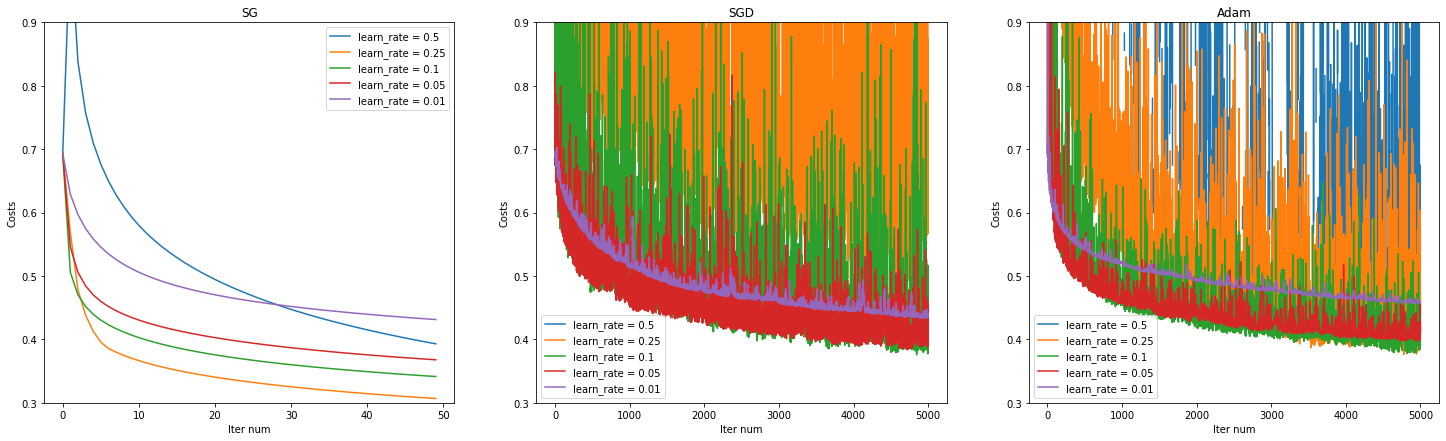

In [69]:
title_names = ["SG", 'SGD', 'Adam']
fig, axs = plt.subplots(1, 3, figsize=(25, 7))

for i in range(3):
    for j in range(len(learn_rate_list) - 1, -1, -1):
        vals = all_results[i][j]['costs'][::]
        #vals_max =
        axs[i].plot(vals, label=f"learn_rate = {learn_rate_list[j]}")

    axs[i].set_title(title_names[i])
    axs[i].set_xlabel("Iter num")
    axs[i].set_ylabel("Costs")
    axs[i].set_ylim([0.3, 0.9])
    axs[i].legend()

The graphs of the three methods differ greatly in the smoothness of the curves.
GD has the smoothest curves because it descends in all directions.
SGD has the most scatter, because due to the random selection of a batch, the result of the loss function can vary greatly. However, this approach allows you to quickly find the minimum.
Adam increase the speed of finding the minimum and reduce the spread of losses.

In [71]:
final_accuracy_results = np.zeros((3, len(learn_rate_list)))

for i in range(3):
    for j in range(len(learn_rate_list)):
        final_accuracy_results[i, j] = accuracy_score(y_test, all_results[i][j]["Y_prediction_test"][0])

lr_name = [f"lr={lr}" for lr in learn_rate_list]
accuracy_table = pd.DataFrame(data=final_accuracy_results, index=['GD', 'SGD', 'Adam'], columns=lr_name)
accuracy_table.round(3)

,lr=0.01,lr=0.05,lr=0.1,lr=0.25,lr=0.5
GD,0.770,0.772,0.763,0.769,0.726
SGD,0.761,0.752,0.756,0.723,0.689
Adam,0.762,0.739,0.753,0.736,0.738


On current data, gradient descent provides the best accuracy. However, if there is much more data, then the application of this method will require significant time resources. To avoid this, Adam or SGD is usually used.